In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# General
import os
import math
import sys
import time
import pickle
import json
import datetime
import random
import seaborn as sns

#import sklearn
import sklearn
from sklearn import *

#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset


In [4]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [5]:
DIR_INPUT='../simulated-data-transformed/data/' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
Wall time: 1.72 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [6]:
transactions_df.shape

(1754155, 23)

In [7]:
# dividing the X and the Y from the dataset
X = transactions_df.drop(['TX_FRAUD'], axis = 1)
Y = transactions_df["TX_FRAUD"]
X=X.drop(['TX_DATETIME'],axis=1)
X=X.drop(['TX_FRAUD_SCENARIO'],axis=1)
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing 
# (its a numpy array with no columns)
xData = X.values
yData = Y.values

(1754155, 20)
(1754155,)


## Balance Dataset


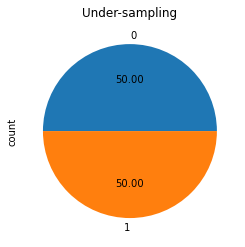

In [8]:
# Random Undersampling 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_res, y_res = rus.fit_resample(X, Y)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [9]:
#class distribution
y_res.value_counts()

TX_FRAUD
0    14681
1    14681
Name: count, dtype: int64

## Train-Test Split


In [10]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(
        X_res, y_res, test_size = 0.2)

## Scaling and Reshaping

In [11]:
# Now we are going to get the bring the data into the same range. 
# StandardScaler() standardizes the features by removing the mean and scaling to unit variance. 
# We will fit scaler only to the training dataset but we will tranform both the training as well as the testing dataset.

In [12]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
XTest = scaler.fit_transform(xTest)

yTrain = yTrain.to_numpy()
yTest = yTest.to_numpy()

xTrain.shape

(23489, 20)

In [13]:
# Our data is 2 dimensional but neural networks accept 3 dimensional data. So we have to reshape() the data.

In [14]:
xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1], 1)
xTest = xTest.values.reshape(xTest.shape[0], xTest.shape[1], 1)

xTrain.shape, xTest.shape

((23489, 20, 1), (5873, 20, 1))

## Build a CNN

In [15]:
# A Sequential() model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

# Conv1D() is a 1D Convolution Layer, this layer is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment. 
# In the first Conv1D() layer we are learning a total of 20 filters with size of convolutional window as 2. The input_shape specifies the shape of the input. It is a necessary parameter for the first layer in any neural network. 
# We will be using ReLu activation function. The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

In [24]:
epochs = 20
model = Sequential()
model.add(Conv1D(20, 2, activation='relu', input_shape = xTrain[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(40, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 19, 20)            60        
                                                                 
 batch_normalization_4 (Batc  (None, 19, 20)           80        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 19, 20)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 40)            1640      
                                                                 
 batch_normalization_5 (Batc  (None, 18, 40)           160       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 18, 40)           

In [26]:
# Now we will compile and fit the model. We are using Adam optimizer with 0.00001 learning rate.
# We will use 20 epochs to train the model. 
# An epoch is an iteration over the entire data provided.validation_data is the data on which to evaluate the loss and any model metrics at the end of each epoch.

In [27]:
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(xTrain, yTrain, epochs=epochs, validation_data=(xTest, yTest), verbose=1, shuffle=True)

Epoch 1/20
735/735 [==============================] - 6s 6ms/step - loss: 0.4749 - accuracy: 0.7928 - val_loss: 2563763.0000 - val_accuracy: 0.5069
Epoch 2/20
735/735 [==============================] - 4s 6ms/step - loss: 0.3961 - accuracy: 0.8294 - val_loss: 3436100.5000 - val_accuracy: 0.5069
Epoch 3/20
735/735 [==============================] - 4s 6ms/step - loss: 0.3822 - accuracy: 0.8375 - val_loss: 3590211.0000 - val_accuracy: 0.5069
Epoch 4/20
735/735 [==============================] - 4s 5ms/step - loss: 0.3754 - accuracy: 0.8429 - val_loss: 5095521.5000 - val_accuracy: 0.5069
Epoch 5/20
735/735 [==============================] - 5s 7ms/step - loss: 0.3733 - accuracy: 0.8470 - val_loss: 5218701.0000 - val_accuracy: 0.5069
Epoch 6/20
735/735 [==============================] - 5s 7ms/step - loss: 0.3627 - accuracy: 0.8499 - val_loss: 4241117.0000 - val_accuracy: 0.5069
Epoch 7/20
735/735 [==============================] - 5s 7ms/step - loss: 0.3596 - accuracy: 0.8526 - val_loss: 

## Visualizing 

In [29]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

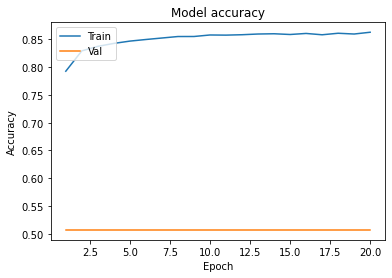

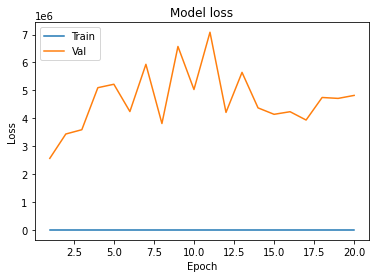

In [30]:
plot_learningCurve(history, epochs)

In [33]:
# We can see that the training accuracy is higher than the validation accuracy. So we can say that they model is overfitting. 
# We can add a MaxPool layer and increase the nuber of epochs to improve our accuracy.

## Adding Maxpool Layer

In [31]:
epochs = 50
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = xTrain[0].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(xTrain, yTrain, epochs=epochs, validation_data=(xTest, yTest), verbose=1, shuffle=True)

Epoch 1/50
735/735 [==============================] - 5s 5ms/step - loss: 0.5678 - accuracy: 0.7303 - val_loss: 608597.1250 - val_accuracy: 0.4929
Epoch 2/50
735/735 [==============================] - 4s 5ms/step - loss: 0.4512 - accuracy: 0.7935 - val_loss: 380707.3438 - val_accuracy: 0.4929
Epoch 3/50
735/735 [==============================] - 4s 5ms/step - loss: 0.4324 - accuracy: 0.8078 - val_loss: 396328.4375 - val_accuracy: 0.4929
Epoch 4/50
735/735 [==============================] - 4s 5ms/step - loss: 0.4165 - accuracy: 0.8161 - val_loss: 388994.9062 - val_accuracy: 0.4929
Epoch 5/50
735/735 [==============================] - 4s 5ms/step - loss: 0.4121 - accuracy: 0.8206 - val_loss: 573749.9375 - val_accuracy: 0.4929
Epoch 6/50
735/735 [==============================] - 4s 5ms/step - loss: 0.3980 - accuracy: 0.8292 - val_loss: 107538.0312 - val_accuracy: 0.4907
Epoch 7/50
735/735 [==============================] - 4s 6ms/step - loss: 0.3954 - accuracy: 0.8295 - val_loss: 225677

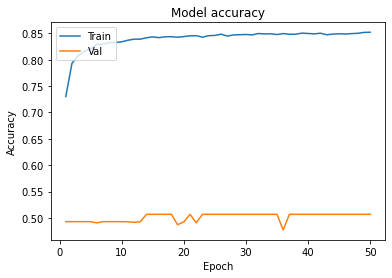

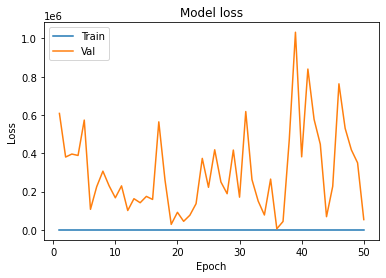

In [32]:
plot_learningCurve(history, epochs)

In [ ]:
#Saving the trained models
pickle.dump(, open('./Trained_Models/DecisionTreemodel.pkl', 'wb'))